In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam




In [2]:
time_window = 10

In [3]:
df = pd.read_csv(r"CNNdata\fulldata.csv")
df["DateTime"] = pd.to_datetime(df["DateTime"])
df.set_index(df["DateTime"], inplace=True)
df = df.resample("100ms").mean()
df = df.fillna(method='ffill')  # Forward fill
df
del df["DateTime"]


C:\Users\dbjac\AppData\Local\Temp\ipykernel_16644\3388434128.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')  # Forward fill


Text(0.5, 1.0, 'Distribution of Log-Returns at 100ms')

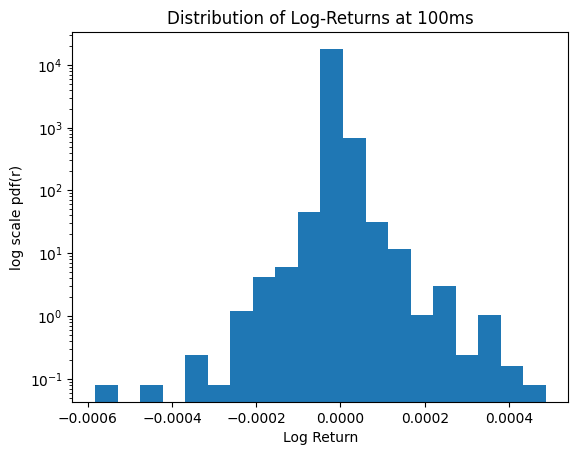

In [5]:
plt.hist(df["Returns"],density=True,bins=20)
plt.yscale("log")
plt.ylabel("log scale pdf(r)")
plt.xlabel("Log Return")
plt.title("Distribution of Log-Returns at 100ms")

In [18]:
print(df.dtypes)
print(df.isnull().sum().cumsum())


Price                 float64
Mid                   float64
WAP                   float64
Returns               float64
Spread                float64
                       ...   
Is_3                  float64
Is_4                  float64
Is_5                  float64
Next_Mid_Direction    float64
Mid_Change            float64
Length: 71, dtype: object
Price                 0
Mid                   0
WAP                   0
Returns               0
Spread                0
                     ..
Is_3                  0
Is_4                  0
Is_5                  0
Next_Mid_Direction    0
Mid_Change            0
Length: 71, dtype: int64


In [19]:
for index in df:
    print(index,df[index].isna().sum())

Price 0
Mid 0
WAP 0
Returns 0
Spread 0
Delta_AP_1 0
Delta_BP_1 0
Size 0
Direction 0
MA5_Order_Direction 0
MA10_Order_Direction 0
MA15_Order_Direction 0
Ask_Price_Level_1 0
Ask_Volume_Level_1 0
Bid_Price_Level_1 0
Bid_Volume_Level_1 0
Ask_Price_Level_2 0
Ask_Volume_Level_2 0
Bid_Price_Level_2 0
Bid_Volume_Level_2 0
Ask_Price_Level_3 0
Ask_Volume_Level_3 0
Bid_Price_Level_3 0
Bid_Volume_Level_3 0
Ask_Price_Level_4 0
Ask_Volume_Level_4 0
Bid_Price_Level_4 0
Bid_Volume_Level_4 0
Ask_Price_Level_5 0
Ask_Volume_Level_5 0
Bid_Price_Level_5 0
Bid_Volume_Level_5 0
Ask_Price_Level_6 0
Ask_Volume_Level_6 0
Bid_Price_Level_6 0
Bid_Volume_Level_6 0
Ask_Price_Level_7 0
Ask_Volume_Level_7 0
Bid_Price_Level_7 0
Bid_Volume_Level_7 0
Ask_Price_Level_8 0
Ask_Volume_Level_8 0
Bid_Price_Level_8 0
Bid_Volume_Level_8 0
Ask_Price_Level_9 0
Ask_Volume_Level_9 0
Bid_Price_Level_9 0
Bid_Volume_Level_9 0
Ask_Price_Level_10 0
Ask_Volume_Level_10 0
Bid_Price_Level_10 0
Bid_Volume_Level_10 0
Ask_Volume 0
Bid_Volume 

(array([1.03443265e-01, 3.20522409e-04, 5.52794314e-02, 7.25021689e-02,
        2.53746907e-01, 4.30025685e+00, 7.40193083e-02, 4.66894309e-02,
        9.61567226e-04, 9.27805533e-02]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

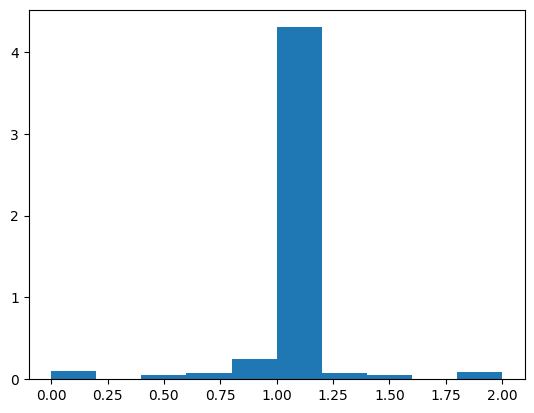

In [20]:
plt.hist(df["Next_Mid_Direction"],density=True)
#plt.hist(df["Mid_Change"],density=True)

In [21]:

X = df.drop(["Next_Mid_Direction","Mid_Change"], axis=1) #Features
y = df["Next_Mid_Direction"] #Target

train_size = int(len(df) * 0.7)  # 70% for training
val_size = int(len(df) * 0.15)    # 15% for validation
test_size = len(df) - train_size - val_size #Remaining for testing

X = df.drop(["Next_Mid_Direction","Mid_Change"], axis=1)
y = df["Next_Mid_Direction"]

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]


df["Size"] = df["Size"].astype(np.float64)

numerical_cols = X_train.select_dtypes(include=np.float64).columns
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

X_train.head()



C:\Users\dbjac\AppData\Local\Temp\ipykernel_28208\4103593463.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
C:\Users\dbjac\AppData\Local\Temp\ipykernel_28208\4103593463.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])
C:\Users\dbjac\AppData\Local\Temp\ipykernel_28208\4103593463.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

,Price,Mid,WAP,Returns,Spread,Delta_AP_1,Delta_BP_1,Size,Direction,MA5_Order_Direction,...,vol_w10,vol_w15,MA_w5,MA_w10,MA_w15,Is_1,Is_2,Is_3,Is_4,Is_5
DateTime,,,,,,,,,,,,,,,,,,,,,
2019-01-03 09:30:00.700,2.545583,2.723657,2.649958,3.976083,5.112764,4.202947,1.609442,0.621563,0.520999,0.711659,...,4.515708,4.507624,5.096245,6.586348,7.684350,0.261797,-0.021644,-0.808170,2.672307,0.866164
2019-01-03 09:30:00.800,2.716901,2.958879,2.809516,-0.012776,7.196984,0.039619,-0.055045,0.951327,0.749977,1.170293,...,-0.412173,-0.493240,-0.010965,-0.012877,-0.007486,-0.785580,-0.021644,0.649312,1.350923,-0.128077
2019-01-03 09:30:00.900,2.643094,2.672047,2.384335,-15.392355,8.695462,0.039619,-21.663114,0.290964,-0.443765,0.088752,...,20.224582,15.375969,-37.500938,-26.717903,-20.795757,0.132225,-0.021644,-0.565257,3.846871,-0.128077
2019-01-03 09:30:01.000,2.710152,2.927966,2.691928,-0.012776,10.984925,0.039619,-0.055045,0.820933,0.537652,0.487910,...,21.702766,21.402716,18.291082,13.057975,1.531150,-0.001274,-0.021644,-0.476924,2.031636,0.896292
2019-01-03 09:30:01.100,2.137847,2.795346,2.545421,-0.012776,13.287572,0.039619,-0.055045,0.397474,1.217094,1.509283,...,16.064304,17.716871,-35.220503,-3.636963,17.877868,1.600712,-0.021644,-1.536911,-0.146646,-0.128077


In [22]:
def create_image_data(X,time_window):
    num_samples = len(X) - time_window + 1
    num_channels = X.shape[1]
    images = np.zeros((num_samples,num_channels,time_window))
    for i in range(num_samples):
        images[i] = X[i:i+time_window].T
    return images

def create_model(input_shape):
    model = keras.Sequential([
        keras.Input(shape=input_shape),  # Input layer (important to define input shape)

        layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),  # Convolutional layer
        layers.BatchNormalization(), #Batch Normalization Layer
        layers.MaxPooling1D(pool_size=2),  # Max pooling

        layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),  # Convolutional layer
        layers.BatchNormalization(), #Batch Normalization Layer
        layers.MaxPooling1D(pool_size=2),  # Max pooling

        layers.Flatten(),  # Flatten the output for the dense layers
        layers.Dense(128, activation='relu'),  # Fully connected layer
        layers.Dropout(0.5),  # Dropout for regularization
        layers.Dense(3,activation="softmax")  # Output layer (3 classes: Down, Stable, Up)
    ])
    return model




In [23]:

X_train_images = create_image_data(X_train, time_window)
y_train_images = y_train.iloc[time_window - 1:len(y_train)].values

X_val_images = create_image_data(X_val,time_window)
y_val_images = y_val.iloc[time_window -1:len(y_train)].values

X_test_images = create_image_data(X_test, time_window)
y_test_images = y_test.iloc[time_window - 1:len(y_test)].values 



KeyboardInterrupt: 

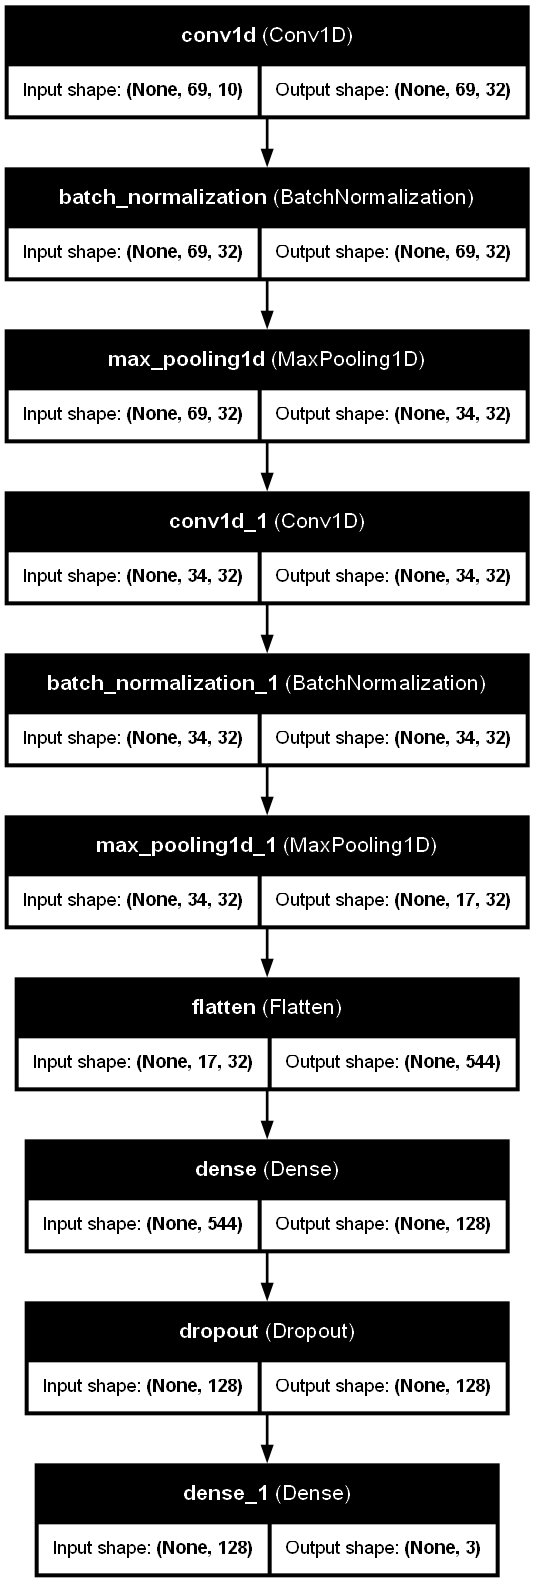

In [ ]:


input_shape = (X_train_images.shape[1], X_train_images.shape[2])
model = create_model(input_shape)
learning_rate = 0.0001  
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

tf.keras.utils.plot_model(model, to_file='cnn_architecture.png', show_shapes=True, show_layer_names=True, dpi=96)





In [12]:
batch_size = 364
epochs = 100

# Train the model
history = model.fit(X_train_images, y_train_images, epochs=epochs, 
                batch_size=batch_size, validation_data=(X_val_images, y_val_images), verbose=1)



Epoch 1/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6460 - loss: 0.9467 - val_accuracy: 0.8012 - val_loss: 0.4060
Epoch 2/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.7886 - loss: 0.4745 - val_accuracy: 0.8012 - val_loss: 0.3919
Epoch 3/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.7946 - loss: 0.4277 - val_accuracy: 0.8010 - val_loss: 0.3857
Epoch 4/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.7968 - loss: 0.4105 - val_accuracy: 0.8008 - val_loss: 0.3789
Epoch 5/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.7993 - loss: 0.3964 - val_accuracy: 0.7996 - val_loss: 0.3748
Epoch 6/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.7963 - loss: 0.3894 - val_accuracy: 0.7979 - val_loss: 0.3724
Epoch 7/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.7976 - loss: 0.3832 - val_accuracy: 0.7984 - val_loss: 0.3662
Epoch 8/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.7966 - loss: 0

In [24]:
print(len(y_train[y_train==2])/len(y_train),len(y_train[y_train==2])," Up")
print(len(y_train[y_train==0])/len(y_train),len(y_train[y_train==0]),"Down")
print(len(y_train[y_train==1])/len(y_train),len(y_train[y_train==1]),"Neutral")
print(len(y_train),"Training Size\n")

print(len(y_test_images[y_test_images==2])/len(y_test_images),len(y_test_images[y_test_images==2])," Up")
print(len(y_test_images[y_test_images==0])/len(y_test_images),len(y_test_images[y_test_images==0])," Down")
print(len(y_test_images[y_test_images==1])/len(y_test_images),len(y_test_images[y_test_images==1])," Neutral")
print(len(y_test_images),"Testing Size")

print("\n",len(y_test_images)/len(y_train_images))

0.018614731829420923 3049  Up
0.021093439970695075 3455 Down
0.8008119905980036 131169 Neutral
163795 Training Size

0.02023310820438289 710  Up
0.016699438602490665 586  Down
0.8194978769485053 28757  Neutral
35091 Testing Size

 0.21424908111804428


1097/1097 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Test Accuracy (using predictions): 0.895215297369696
              precision    recall  f1-score   support

           0       0.55      0.23      0.33      3098
           1       0.91      0.98      0.94     31283
           2       0.00      0.00      0.00       710

    accuracy                           0.90     35091
   macro avg       0.49      0.40      0.42     35091
weighted avg       0.86      0.90      0.87     35091

[[  724  2374     0]
 [  586 30690     7]
 [    5   705     0]]
Test Accuracy (using model.evaluate): 0.8052207231521606


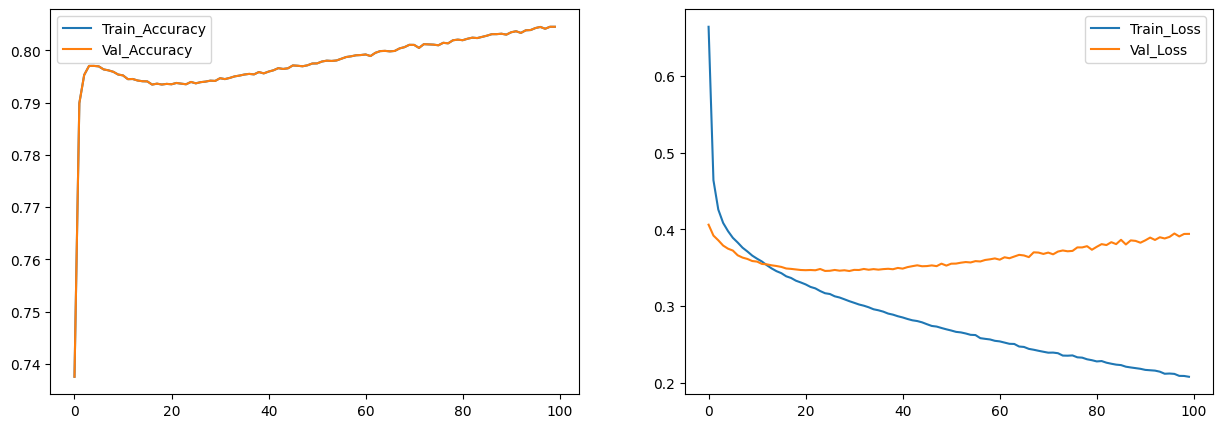

In [25]:
#Make predictions
predictions = model.predict(X_test_images)
predicted_labels = np.argmax(predictions, axis=1) #Axis 1 is for each sample
accuracy = accuracy_score(y_test_images.astype(int), predicted_labels)
print(f"Test Accuracy (using predictions): {accuracy}")

#Print classification report
print(classification_report(y_test_images.astype(int),predicted_labels))

#Print confusion matrix
print(confusion_matrix(y_test_images.astype(int),predicted_labels))

# Compare with model.evaluate (should be the same)
loss, accuracy_eval = model.evaluate(X_test_images, y_test_images, verbose=0)
print(f"Test Accuracy (using model.evaluate): {accuracy_eval}")

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(history.history["accuracy"],label="Train_Accuracy")
ax[0].plot(history.history["accuracy"],label="Val_Accuracy")
ax[1].plot(history.history["loss"],label="Train_Loss")
ax[1].plot(history.history["val_loss"],label="Val_Loss")
ax[0].legend()
ax[1].legend()
